# I. Imports and installs


Herebelow are all the packages I will use in this notebook. I used tensorflow/keras for the model creation, training and benchmarks. 

In [11]:
import numpy as np
import tensorflow as tf
from keras import layers, models, metrics, losses, callbacks, optimizers
import matplotlib.pyplot as plt
import cv2
import glob
import os
import zipfile
import requests
import random
import shutil


# II. Load dataset #

This part loads the dataset and applies a basic preprocessing to prepare the model input: conversion to grayscale and application of a sharpen filter. 

In [72]:
CKAN_DATASET_ID = "1d009ea5-be6f-466d-bd72-49588dee98c5"
DATASET_DIRECTORY = os.getcwd() + f"\\{CKAN_DATASET_ID}\\Retina Blood Vessel Segmentation"

In [73]:
# Extracting zip file
def extract_zip(ckan_dataset_id: str):
    with zipfile.ZipFile(f'{ckan_dataset_id}.zip', 'r') as zip_ref:
        zip_ref.extractall(f'{ckan_dataset_id}')

#  {{CKAN_API_URL}} = http://192.168.1.15:30020
#  b987cf48-1b6c-44c7-981a-d25da07f1cd3
# Loading dataset
def load_data(ckan_dataset_id: str):
    url = "http://192.168.1.15:30020" + f"/api/3/action/package_show?id={ckan_dataset_id}"
    response = requests.get(url, verify=False)
    fetch_data = response.json()
    resources = fetch_data["result"]["resources"]
    zip_resource = None
    for resource in resources:
        if resource['format'].lower() == 'zip':
            zip_resource = resource
            break
    if zip_resource is None:
        raise ValueError("No zip file found in the dataset")

    zip_url = zip_resource['url']
    zip_response = requests.get(zip_url)
    with open(f'{ckan_dataset_id}.zip', 'wb') as f:
        f.write(zip_response.content)

    extract_zip(ckan_dataset_id)
    os.remove(f'{ckan_dataset_id}.zip')

load_data(CKAN_DATASET_ID)

In [78]:
PATH = CKAN_DATASET_ID + "\\Retina Blood Vessel Segmentation"

In [97]:
def read_dataset(file_path):
    split_ratio = 0.8
    image_files = sorted(glob.glob(PATH + "\\image\\*.png"))
    mask_files = sorted(glob.glob(PATH + "\\mask\\*.png"))

    train_image_files = image_files[:int(len(image_files) * split_ratio)]
    test_image_files = image_files[int(len(image_files) * split_ratio):]
    train_mask_files = mask_files[int(len(mask_files) * split_ratio):]
    test_maks_files = mask_files[:int(len(mask_files) * split_ratio)]

    train_images = np.array([cv2.imread(file_name, cv2.IMREAD_COLOR) for file_name in train_image_files])
    test_images = np.array([cv2.imread(file_name, cv2.IMREAD_COLOR) for file_name in test_image_files])
    train_masks = np.array([cv2.imread(file_name, cv2.IMREAD_COLOR) for file_name in train_mask_files])
    test_masks = np.array([cv2.imread(file_name, cv2.IMREAD_COLOR) for file_name in test_maks_files])
    
    train_images = train_images / 255.0
    train_masks = train_masks / 255.0
    test_images = test_images / 255.0
    test_masks = test_masks / 255.0
        
    print('Train images shape:', train_images.shape)
    print('Train masks shape:', train_masks.shape)
    print('Test images shape:', test_images.shape)
    print('Test masks shape:', test_masks.shape)

    return train_images, train_masks, test_images, test_masks

x_train, y_train, x_test, y_test = read_dataset(PATH)

Train images shape: (80, 512, 512, 3)
Train masks shape: (20, 512, 512, 3)
Test images shape: (20, 512, 512, 3)
Test masks shape: (80, 512, 512, 3)


In [98]:
def basic_preprocessing(x):
  result = np.zeros(x.shape[:-1])
  for idx in range(len(x)):
    img = x[idx]
    img = 0.3 * img[:, :, 0] + 0.5 * img[:, :, 1] + 0.2 * img[:, :, 2]
    img = cv2.filter2D(src=img, ddepth=-1, kernel=np.array([[0, -1, 0],
                                                            [-1, 5, -1],
                                                            [0, -1, 0]]))
    result[idx, :, :] = img
  return np.expand_dims(result, axis=-1)

x_train = basic_preprocessing(x_train)
x_test = basic_preprocessing(x_test)

# III. Create the metrics #

I use the basic metrics described in the dataset data card, as well as the cosine similarity, which quantifies how the images are aligned mathematically. 

To compute the F1 score, I apply a 0.5 treshold to both the prediction and the ground truth to obtain the classes of each pixel. Then, I calculate the dice coefficient between those images (which is the F1 score).

In [4]:
def digitize(y, treshold=0.5):
  return tf.cast(tf.greater_equal(y, treshold), tf.float32)

def IoU(y_true, y_pred):
  y_true = digitize(y_true)
  y_pred = digitize(y_pred)
  intersection = tf.multiply(y_true, y_pred)
  suminter = tf.reduce_sum(intersection)
  return suminter / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - suminter)

def dice_coefficient(y_true, y_pred):
  y_true = digitize(y_true)
  y_pred = digitize(y_pred)
  intersection = tf.multiply(y_true, y_pred)
  suminter = tf.reduce_sum(intersection)
  return 2 * suminter / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

def cossine_similarity(y_true, y_pred):
  y_true = tf.reshape(y_true, [-1])
  y_pred = tf.reshape(y_pred, [-1])

  yt_norm = tf.sqrt(tf.reduce_sum(tf.square(y_true)))
  yp_norm = tf.sqrt(tf.reduce_sum(tf.square(y_pred)))

  if yp_norm == 0 or yt_norm == 0:
    return 0.0

  return tf.tensordot(y_true, y_pred, 1) / (yp_norm * yt_norm)

# IV Pre-process the data #

This part defines the functions used for data augmentation and generates the batches.
The data augmentation is made of 5 parts:
1. Convert to grayscale and apply a sharpen filter (already done in the basic_preprocessing function)
2. Randomly crop  the initial image (I use 96x96 crops here)
3. Apply one of the following effetcs: nothing, flip, rotate by a multiple of 90°
4. Apply one of the following effects: nothing, invert color
5. Apply one of the following effects: nothing, uniform noise, random square on the image

This ensure that no crop is ever seen twice by the model during training, therefore there is virtually no overfitting.


In [5]:
def crop(x, y, crop_size=64):
  start_x = np.random.randint(0, x.shape[0] - crop_size)
  start_y = np.random.randint(0, x.shape[1] - crop_size)

  x = x[start_x:start_x+crop_size, start_y:start_y+crop_size, :]
  y = y[start_x:start_x+crop_size, start_y:start_y+crop_size]

  return x, y

def flip(x, y):
  flip_type = np.random.randint(0, 3)
  match(flip_type):
    case 0: # Horizontal flip
      x = x[::-1, :, :]
      y = y[::-1, :]
      return x, y
    case 1: # Vertical flip
      x = x[:, ::-1, :]
      y = y[:, ::-1]
      return x, y
    case 2: # Horizontal + vertical flip
      x = x[::-1, ::-1, :]
      y = y[::-1, ::-1]
      return x, y

def rotate90(x, y):
  angle = np.random.randint(1, 4)
  for _ in range(angle):
    x = cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE)
    y = cv2.rotate(y, cv2.ROTATE_90_CLOCKWISE)
  return np.expand_dims(x, axis=-1), y

def invert(x, y):
  return 1-x, y

def shuffle_channels(x, y):
  shuffle_idx = np.random.randint(3)
  match(shuffle_idx):
    case 0:
      x[:, :, 0], x[:, :, 1] = x[:, :, 1], x[:, :, 0]
      return x, y
    case 1:
      x[:, :, 1], x[:, :, 2] = x[:, :, 2], x[:, :, 1]
      return x, y
    case 2:
      x[:, :, 2], x[:, :, 0] = x[:, :, 0], x[:, :, 2]
      return x, y

def noise(x, y):
  noise = 0.08 * np.random.rand(*x.shape)
  return np.clip(x+noise, 0, 1), y

def random_square(x, y, size=8):
  start_x = np.random.randint(0, x.shape[0] - size)
  start_y = np.random.randint(0, x.shape[1] - size)

  color = np.random.rand(1,)

  x[start_x:start_x+size, start_y:start_y+size, :] = color
  y[start_x:start_x+size, start_y:start_y+size] = 0

  return x, y

def apply_preprocessing(x, y, crop_size=64):
  x = np.copy(x)
  y = np.copy(y)
  x, y = crop(x, y, crop_size)

  x = np.clip(x, 0, 1)

  identity = lambda a, b: (a, b)

  preprocessing_first=[
      identity,
      flip,
      rotate90
  ]
  preprocessing_second=[
      identity,
      invert
  ]
  preprocessing_last=[
      identity,
      noise,
      (lambda x, y: random_square(x, y, crop_size//4))
  ]

  first_prob = [0.34, 0.33, 0.33]
  second_prob = [0.9, 0.1]
  last_prob = [0.8, 0.15, 0.05]

  first_pp = np.random.choice(len(preprocessing_first), 1, p=first_prob)[0]
  x, y = preprocessing_first[first_pp](x, y)
  second_pp = np.random.choice(len(preprocessing_second), 1, p=second_prob)[0]
  x, y = preprocessing_second[second_pp](x, y)
  last_pp = np.random.choice(len(preprocessing_last), 1, p=last_prob)[0]

  return preprocessing_last[last_pp](x, y)

We can see below the advantage of using a sharpen filter: the smallest blood vessels can now be distinguished much more clearly. 

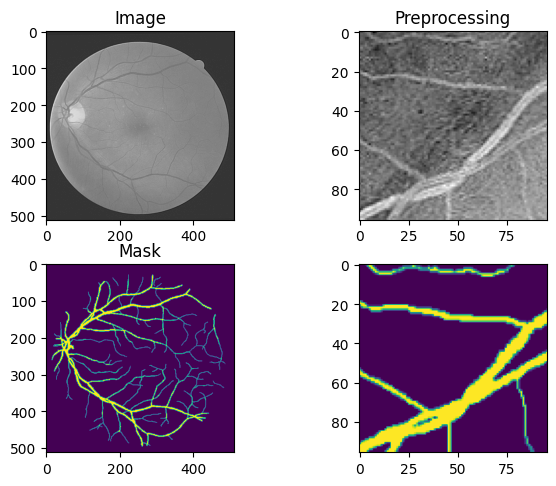

In [6]:
def display_preprocessing(xt, yt):
  idx = np.random.choice(len(xt), 1)[0]
  img = xt[idx]
  mask = yt[idx]

  xcrop, ycrop = crop(img, mask)

  xshow = xcrop
  yshow = ycrop

  for k in range(100):
    xshow, yshow = apply_preprocessing(img, mask, 96)

  fig, axs = plt.subplots(2, 2)
  fig.tight_layout()

  axs[0][0].set_title('Image')
  axs[0][0].imshow(img, cmap='gray')
  axs[1][0].set_title('Mask')
  axs[1][0].imshow(mask)

  axs[0][1].set_title(f'Preprocessing')
  axs[0][1].imshow(xshow, cmap='gray')
  axs[1][1].imshow(yshow)
  plt.show()

display_preprocessing(x_train, y_train)

This function creates the validation data (I use a seed to always have the same train/validation split) and the batch generator. All the batches necessary for a single epochs are fabricated before the epoch to have a faster training. 

In [7]:
def batch_generation(x, y, batch_size, crop_size=96, batch_multiplication=10):
  np.random.seed(1)
  valid_indexes = np.random.choice(len(x), len(x) // 10, replace=False)
  train_indexes = [k for k in range(len(x)) if k not in valid_indexes]

  x_train = x[train_indexes]
  y_train = y[train_indexes]
  x_valid = x[valid_indexes]
  y_valid = y[valid_indexes]

  reduced_steps_per_epoch = 1 + len(x_train) // batch_size
  steps_per_epoch = 1 + batch_multiplication * len(x_train) // batch_size


  def batch_generator():
    while True:
      batches = []
      for step in range(reduced_steps_per_epoch):
        low_idx = step * batch_size
        high_idx = min(low_idx+batch_size, len(x_train))
        x_images = x_train[low_idx:high_idx]
        y_masks = y_train[low_idx:high_idx]
        for _ in range(batch_multiplication):
          x_batch = []
          y_batch = []
          for idx in range(len(x_images)):
            xpp, ypp = apply_preprocessing(x_images[idx], y_masks[idx], crop_size)
            x_batch.append(xpp)
            y_batch.append(ypp)
          x_batch = np.stack(x_batch, axis=0)
          y_batch = np.stack(y_batch, axis=0)
          batches.append([x_batch, y_batch])
      for step in range(steps_per_epoch):
        yield batches[step][0], batches[step][1]

  return batch_generator, x_valid, y_valid, steps_per_epoch

# V. Create the model #

I use a unet3plus model. Here are the results I got in terms of test F1 socre with other architectures (not present in this notebook):
* custom unet (using bottleneck/depthwise separable convolutions, 4 encoder steps): 79.5% F1, 2.6m parameters
* normal unet (4 encoder steps): 80% F1, 9.0m parameters
* unet3+ with 3 encoder steps: 81.5% F1, 1.3m parameters
* unet3+ with 4 encoder steps (no DS): 81.5% F1, 1.0m parameters
* unet3+ with 4 encoder steps (with DS): 83% F1, 1.6m parameters

Those trainings were performed on google colab using T4 gpus. 
At equal number of parameters, the unet3+ architecture is far superior than the unet architecture. Deep supervision helps optimizing the model training. I did not try to use deep supervision with the basic unet model but it would be interesting to try. The deep supervision used here is fully adaptable to the basic unet architecture (unlike unet2+ deep supervision).

Using bottleneck convolution blocks and depthwise separable convolution blocks can help reduce significantly the number of parameters without losing too much accuracy.

In [8]:
def create_unet3plus_model(input_shape=(None, None, 1), f0=32, encoder_blocks=4):
  f_lat =   f0 * 2 ** (encoder_blocks+1)

  inputs = layers.Input(input_shape)
  x = inputs
  skips = {}

  for block in range(encoder_blocks):
    f_block = f0 * 2 ** (block+1)
    s = layers.Conv2D(f_block, (3, 3), padding='same', name=f'encoder{block}_conv')(x)
    s = layers.BatchNormalization(name=f'encoder{block}_bn')(s)
    s = layers.Activation('relu', name=f'encoder{block}_activation')(s)
    x = layers.MaxPooling2D((2, 2), name=f'encoder{block}_maxpool')(s)

    skips[f'encoder{block}'] = s

  lat = layers.Conv2D(f_lat, (1, 1), padding='same', name='latent_pw')(x)
  lat = layers.BatchNormalization(name='latent_bn1')(lat)
  lat = layers.Activation('relu', name='latent_activation1')(lat)
  lat = layers.DepthwiseConv2D((3, 3), padding='same', name='latent_dw')(lat)
  lat = layers.BatchNormalization(name='latent_bn2')(lat)
  lat = layers.Activation('relu', name='latent_activation2')(lat)

  for block in range(encoder_blocks-1, -1, -1):
    up = 2 ** (encoder_blocks-block)
    lat_skip = layers.UpSampling2D((up, up), name=f'latent_skip{up}_up')(lat)
    lat_skip = layers.Conv2D(f0*2, (3, 3), padding='same', name=f'latent_skip{up}_conv')(lat_skip)
    lat_skip = layers.BatchNormalization(name=f'latent_skip{up}_bn')(lat_skip)
    lat_skip = layers.Activation('relu', name=f'latent_skip{up}_activation')(lat_skip)
    encoder_skips = []
    for skip in range(block, -1, -1):
      encoder_skip = skips[f'encoder{skip}']
      down = 2 ** (block-skip)
      encoder_skip = layers.MaxPooling2D((down, down), name=f'encoder{skip}_skip{down}_down')(encoder_skip)
      encoder_skip = layers.Conv2D(f0*2, (3, 3), padding='same', name=f'encoder{skip}_skip{down}_conv')(encoder_skip)
      encoder_skip = layers.BatchNormalization(name=f'encoder{skip}_skip{down}_bn')(encoder_skip)
      encoder_skip = layers.Activation('relu', name=f'encoder{skip}_skip{down}_activation')(encoder_skip)
      encoder_skips.append(encoder_skip)
    decoder_skips = []
    for skip in range(block+1, encoder_blocks):
      decoder_skip = skips[f'decoder{skip}']
      up = 2 ** (skip-block)
      decoder_skip = layers.UpSampling2D((up, up), name=f'decoder{skip}_skip{up}_up')(decoder_skip)
      decoder_skip = layers.Conv2D(f0*2, (3, 3), padding='same', name=f'decoder{skip}_skip{up}_conv')(decoder_skip)
      decoder_skip = layers.BatchNormalization(name=f'decoder{skip}_skip{up}_bn')(decoder_skip)
      decoder_skip = layers.Activation('relu', name=f'decoder{skip}_skip{up}_activation')(decoder_skip)
      decoder_skips.append(decoder_skip)
    x = layers.concatenate([lat_skip, *encoder_skips, *decoder_skips], name=f'decoder{block}_concatenate')
    x = layers.Conv2D(f0*2, (3, 3), padding='same', name=f'decoder{block}_conv')(x)
    x = layers.BatchNormalization(name=f'decoder{block}_bn')(x)
    x = layers.Activation('relu', name=f'decoder{block}_activation')(x)
    skips[f'decoder{block}'] = x

  head_conv = layers.Conv2D(f0, (3, 3), padding='same', name='head_conv')
  head_bn = layers.BatchNormalization(name='head_bn')
  head_activ = layers.Activation('relu', name='head_activation')
  head_out = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid', name='head_conv_out')

  outputs = []
  for block in range(encoder_blocks):
    out_block = skips[f'decoder{block}']
    up = 2 ** block
    out_block = layers.UpSampling2D((up, up), name=f'deep_supervision{block}_up', interpolation='bilinear')(out_block)
    out_block = head_conv(out_block)
    out_block = head_bn(out_block)
    out_block = head_activ(out_block)
    out_block = head_out(out_block)
    outputs.append(out_block)

  return models.Model(inputs=inputs, outputs=outputs)

unet3plus_model = create_unet3plus_model()
unet3plus_model.summary(line_length=140)

Model: "model"
____________________________________________________________________________________________________________________________________________
 Layer (type)                             Output Shape                              Param #       Connected to                              
 input_1 (InputLayer)                     [(None, None, None, 1)]                   0             []                                        
                                                                                                                                            
 encoder0_conv (Conv2D)                   (None, None, None, 64)                    640           ['input_1[0][0]']                         
                                                                                                                                            
 encoder0_bn (BatchNormalization)         (None, None, None, 64)                    256           ['encoder0_conv[0][0]']                  

# VI. Train the model #

The training is separated in 3 parts adapted to the task. 
* The first step uses mae and mse to approximate best the wanted mask.
* The second part uses a combination of mae, mse, dice and iou to have a smooth transition to the last part.
* The third part uses dice and iou because those are the metrics we want to optimize.

The file name contains:  
\<architecture\>\<number-of-params\>\_\<grayscale or rgb input\>\_\<deep supervision\>

In [9]:
def dice_loss(y_true, y_pred, smooth=1):
  intersection = tf.multiply(y_true, y_pred)
  return 1 - (2 * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou_loss(y_true, y_pred, smooth=1):
  intersection =  tf.reduce_sum(tf.multiply(y_true, y_pred))
  return 1 - (intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + smooth)

def mae(y_true, y_pred):
  return tf.reduce_mean(tf.abs(y_true - y_pred))

def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

def custom_loss(losses, weights):
  def loss(y_true, y_pred):
    value = tf.constant([0.0])
    for l, w in zip(losses, weights):
      value += l(y_true, y_pred) * w
    return value
  return loss

file_name = 'unet3plus1608k_gs_ds.h5'

In [10]:
batch_size = 20

batch_generator, x_valid, y_valid, steps_per_epoch = batch_generation(x_train, y_train, batch_size,
                                                                      batch_multiplication=60)

checkpoint = callbacks.ModelCheckpoint(file_name,
                                       monitor='val_head_conv_out_dice_coefficient',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='max')

loss_scheduling = [
    [30, custom_loss([mse, mae], [1, 1])],
    [30, custom_loss([mse, mae, dice_loss, iou_loss], [1, 1, 1, 1])],
    [30, custom_loss([dice_loss, iou_loss], [1, 1])]
]
learning_rate = 1e-3

for [epochs, loss] in loss_scheduling:
  unet3plus_model.compile(loss=loss, optimizer='adam', metrics=[metrics.RootMeanSquaredError(),
                                                           metrics.MeanAbsoluteError(),
                                                           cossine_similarity,
                                                           IoU,
                                                           dice_coefficient])
  unet3plus_model.fit(batch_generator(), epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=(x_valid, y_valid),
                      validation_batch_size=1, callbacks=[checkpoint])

Epoch 1/30
217/217 [==============================] - ETA: 0s - loss: 0.6343 - head_conv_out_loss: 0.1422 - head_conv_out_1_loss: 0.1460 - head_conv_out_2_loss: 0.1571 - head_conv_out_3_loss: 0.1890 - head_conv_out_root_mean_squared_error: 0.2224 - head_conv_out_mean_absolute_error: 0.0927 - head_conv_out_cossine_similarity: 0.7245 - head_conv_out_IoU: 0.4386 - head_conv_out_dice_coefficient: 0.5954 - head_conv_out_1_root_mean_squared_error: 0.2240 - head_conv_out_1_mean_absolute_error: 0.0958 - head_conv_out_1_cossine_similarity: 0.7214 - head_conv_out_1_IoU: 0.4269 - head_conv_out_1_dice_coefficient: 0.5852 - head_conv_out_2_root_mean_squared_error: 0.2327 - head_conv_out_2_mean_absolute_error: 0.1029 - head_conv_out_2_cossine_similarity: 0.6918 - head_conv_out_2_IoU: 0.3759 - head_conv_out_2_dice_coefficient: 0.5285 - head_conv_out_3_root_mean_squared_error: 0.2598 - head_conv_out_3_mean_absolute_error: 0.1215 - head_conv_out_3_cossine_similarity: 0.5908 - head_conv_out_3_IoU: 0.243

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 80s 229ms/step - loss: 0.6343 - head_conv_out_loss: 0.1422 - head_conv_out_1_loss: 0.1460 - head_conv_out_2_loss: 0.1571 - head_conv_out_3_loss: 0.1890 - head_conv_out_root_mean_squared_error: 0.2224 - head_conv_out_mean_absolute_error: 0.0927 - head_conv_out_cossine_similarity: 0.7245 - head_conv_out_IoU: 0.4386 - head_conv_out_dice_coefficient: 0.5954 - head_conv_out_1_root_mean_squared_error: 0.2240 - head_conv_out_1_mean_absolute_error: 0.0958 - head_conv_out_1_cossine_similarity: 0.7214 - head_conv_out_1_IoU: 0.4269 - head_conv_out_1_dice_coefficient: 0.5852 - head_conv_out_2_root_mean_squared_error: 0.2327 - head_conv_out_2_mean_absolute_error: 0.1029 - head_conv_out_2_cossine_similarity: 0.6918 - head_conv_out_2_IoU: 0.3759 - head_conv_out_2_dice_coefficient: 0.5285 - head_conv_out_3_root_mean_squared_error: 0.2598 - head_conv_out_3_mean_absolute_error: 0.1215 - head_conv_out_3_cossine_similarity: 0.5908 - head_conv_out_3_IoU: 0.2438 - 

# VII. Benchmark the model #


1/1 [==============================] - 0s 22ms/step


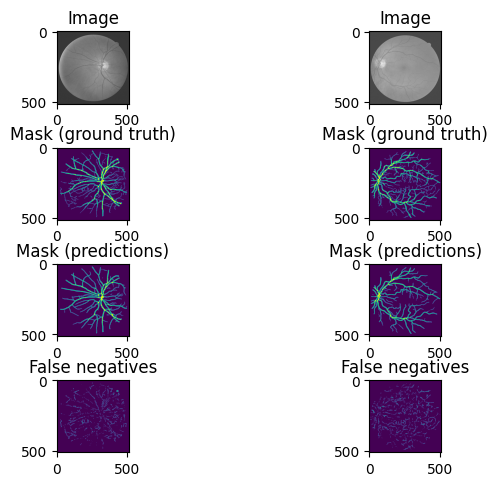

In [13]:
def show_prediction(x, y, model, n=2):
  fig, axs = plt.subplots(4, n)
  fig.tight_layout()
  img_indices = np.random.choice(len(x), n, replace=False)
  images = x[img_indices]
  masks = y[img_indices]
  for k in range(n):
    axs[0][k].set_title("Image")
    axs[0][k].imshow(images[k], cmap='gray')
    axs[1][k].set_title("Mask (ground truth)")
    mask = masks[k]
    mask = digitize(mask)
    axs[1][k].imshow(mask)
    axs[2][k].set_title("Mask (predictions)")
    y_pred = model.predict(np.expand_dims(images[k], axis=0))[0][0]
    y_pred = digitize(y_pred)
    axs[2][k].imshow(y_pred)
    axs[3][k].set_title("False negatives")
    missing = np.where(np.logical_and(np.expand_dims(mask, axis=-1) == 1, y_pred == 0), 1.0, 0)
    axs[3][k].imshow(missing)

  plt.show()

best_model = models.load_model(file_name,
                               custom_objects={
                                 'loss': custom_loss([dice_loss, iou_loss], [1, 1]),
                                 'cossine_similarity': cossine_similarity,
                                 'IoU': IoU,
                                 'dice_coefficient': dice_coefficient})
show_prediction(x_test, y_test, best_model)

In [14]:
def evaluate_model(model, xt, yt, xte, yte):
  _, loss, _, _, _, rmse, mae, cossim, iou, dicecoef, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _ = model.evaluate(xt, yt, batch_size=1)
  train_metrics = [loss, rmse, mae, cossim, iou, dicecoef]
  _, loss, _, _, _, rmse, mae, cossim, iou, dicecoef, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _ = model.evaluate(xte, yte, batch_size=1)
  test_metrics = [loss, rmse, mae, cossim, iou, dicecoef]

  loss, rmse, mae, cossim, iou, dicecoef = train_metrics
  print("Train loss", loss)
  print("Train rmse", rmse, "(", round(255*rmse, 2), " avg pixel error)")
  print("Train mae", mae, "(", round(255*mae, 2), " avg pixel error)")
  print("Train cossine similarity", cossim, "(", round(100*cossim, 2), " %)")
  print("Train iou", iou, "(", round(100*iou, 2), " %)")
  print("Train dice coefficient (F1 score)", dicecoef, "(", round(100*dicecoef, 2), " %)")
  print()
  loss, rmse, mae, cossim, iou, dicecoef = test_metrics
  print("Test loss", loss)
  print("Test rmse", rmse, "(", round(255*rmse, 2), " avg pixel error)")
  print("Test mae", mae, "(", round(255*mae, 2), " avg pixel error)")
  print("Test cossine similarity", cossim, "(", round(100*cossim, 2), " %)")
  print("Test iou", iou, "(", round(100*iou, 2), " %)")
  print("Test dice coefficient (F1 score)", dicecoef , "(", round(100*dicecoef, 2), " %)")

evaluate_model(best_model, x_train, y_train, x_test, y_test)

20/20 [==============================] - 2s 90ms/step - loss: 2.3005 - head_conv_out_loss: 0.5437 - head_conv_out_1_loss: 0.5508 - head_conv_out_2_loss: 0.5784 - head_conv_out_3_loss: 0.6275 - head_conv_out_root_mean_squared_error: 0.1559 - head_conv_out_mean_absolute_error: 0.0354 - head_conv_out_cossine_similarity: 0.8541 - head_conv_out_IoU: 0.6852 - head_conv_out_dice_coefficient: 0.8130 - head_conv_out_1_root_mean_squared_error: 0.1534 - head_conv_out_1_mean_absolute_error: 0.0348 - head_conv_out_1_cossine_similarity: 0.8542 - head_conv_out_1_IoU: 0.6817 - head_conv_out_1_dice_coefficient: 0.8104 - head_conv_out_2_root_mean_squared_error: 0.1540 - head_conv_out_2_mean_absolute_error: 0.0351 - head_conv_out_2_cossine_similarity: 0.8458 - head_conv_out_2_IoU: 0.6657 - head_conv_out_2_dice_coefficient: 0.7989 - head_conv_out_3_root_mean_squared_error: 0.1618 - head_conv_out_3_mean_absolute_error: 0.0383 - head_conv_out_3_cossine_similarity: 0.8295 - head_conv_out_3_IoU: 0.6347 - head